# DeepDreamArt: Professional Notebook for DeepDream Image Generation

### Project Overview
Welcome to *`DeepDreamArt`* This notebook demonstrates how to generate surreal and artistic images using Google's DeepDream algorithm. The process involves using a pre-trained convolutional neural network to enhance and visualize the features of an input image by maximizing activations from various layers.

### Setup and Imports
Start by importing the necessary libraries and loading the base image. We'll also display the image for visualization.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16
import time
from tqdm.notebook import tqdm


48581/48581 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


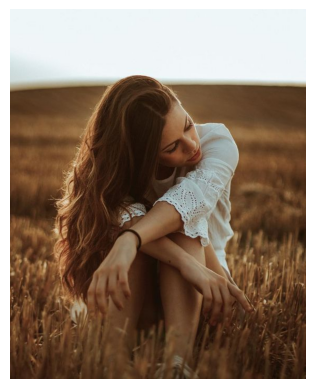

In [ ]:
# Load the base image
base_image_path = keras.utils.get_file(
    "img.jpg", origin="https://i.pinimg.com/736x/08/e8/b4/08e8b468ce7b3fa5b7ec564eb3e711c6.jpg"
)

# Display the base image
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))
plt.show()

### Load Pre-trained Models
We will use InceptionV3, ResNet50, and VGG16 as the feature extraction networks.

In [ ]:
# Load pre-trained models
models = {
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False),
    "ResNet50": ResNet50(weights="imagenet", include_top=False),
    "VGG16": VGG16(weights="imagenet", include_top=False),
}


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Preprocess Image
The image will be loaded, resized, and preprocessed to fit the input requirements of the pre-trained models.

In [ ]:
# Preprocess the image
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

original_img = preprocess_image(base_image_path)


### Feature Extractor Model for Each Network
Each model will extract features from intermediate layers. We'll use the same approach for all three models: InceptionV3, ResNet50, and VGG16.

In [ ]:
# Configure layer settings for different models
layer_settings = {
    "InceptionV3": {
        "mixed4": 1.0,
        "mixed5": 1.5,
        "mixed6": 2.0,
        "mixed7": 2.5,
    },
    "ResNet50": {
        "conv5_block3_out": 1.0,
        "conv5_block4_out": 1.5,
        "conv4_block6_out": 2.0,
    },
    "VGG16": {
        "block5_conv3": 1.0,
        "block4_conv3": 1.5,
        "block3_conv3": 2.0,
    }
}

# Create feature extractor model
def create_feature_extractor(model, layer_settings):
    outputs_dict = {
        layer.name: layer.output
        for layer in model.layers if layer.name in layer_settings
    }
    return keras.Model(inputs=model.input, outputs=outputs_dict)

feature_extractors = {model_name: create_feature_extractor(model, layer_settings[model_name])
                      for model_name, model in models.items()}


### Compute DeepDream Loss
We need to compute the loss to maximize based on the activations of the chosen layers.

In [ ]:
def compute_loss(input_image, feature_extractor, layer_settings):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())

    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss


### Gradient Ascent Step
This step computes the gradient of the loss with respect to the image and updates the image.

In [ ]:
@tf.function
def gradient_ascent_step(image, feature_extractor, learning_rate, layer_settings):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, feature_extractor, layer_settings)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


### Gradient Ascent Loop
This loop runs the gradient ascent for a given number of iterations, progressively improving the image.

In [ ]:
def gradient_ascent_loop(image, feature_extractor, layer_settings, iterations, learning_rate, max_loss=None):
    for i in tqdm(range(iterations), desc="Processing Image"):
        loss, image = gradient_ascent_step(image, feature_extractor, learning_rate, layer_settings)
        if max_loss is not None and loss > max_loss:
            break
        if i % 5 == 0:
            print(f"... Loss at step {i}: {loss:.2f}")
    return image


### Multi-Layer Dreaming and Comparison
We will run DeepDream for each model and display the results side-by-side.

Applying DeepDream using InceptionV3...


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 0.81
... Loss at step 5: 0.87
... Loss at step 10: 0.94
... Loss at step 15: 0.99
Applying DeepDream using ResNet50...


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 4.21
... Loss at step 5: 4.25
... Loss at step 10: 4.29
... Loss at step 15: 4.32
Applying DeepDream using VGG16...


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

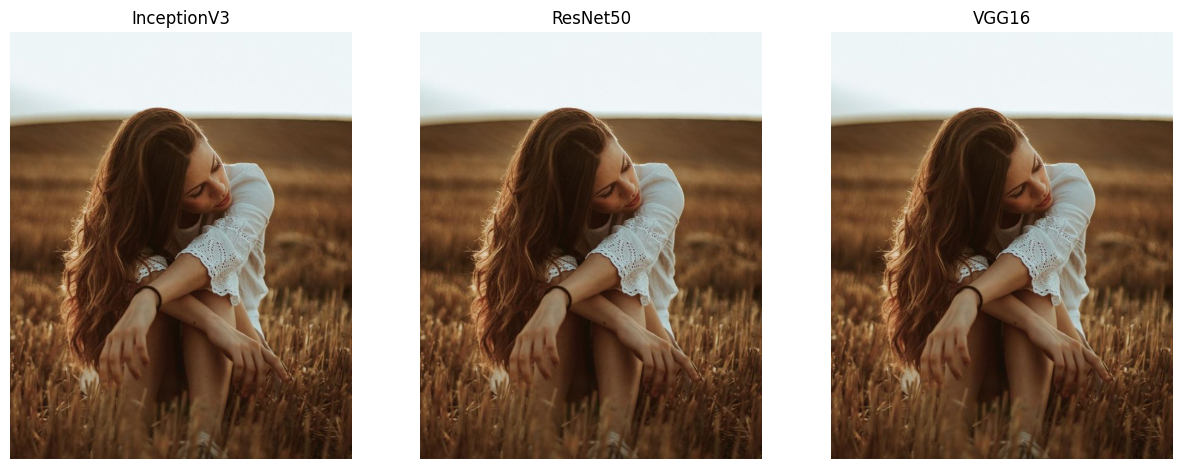

In [ ]:
# Function to apply DeepDream and save the result for each model
def apply_deepdream(model_name, image, feature_extractor, layer_settings, learning_rate=0.1, iterations=20, max_loss=15):
    img = tf.identity(image)
    img = gradient_ascent_loop(img, feature_extractor, layer_settings, iterations, learning_rate, max_loss)
    return deprocess_image(img.numpy())

# Generate DeepDream images for all models
deepdream_images = {}
for model_name in models.keys():
    print(f"Applying DeepDream using {model_name}...")
    deepdream_images[model_name] = apply_deepdream(
        model_name, original_img, feature_extractors[model_name], layer_settings[model_name]
    )

# Plot all results side by side
fig, axes = plt.subplots(1, len(models), figsize=(15, 10))
for i, (model_name, img) in enumerate(deepdream_images.items()):
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(model_name)
plt.show()
